In [7]:
from os import environ

environ['optimizer'] = 'Adam'
environ['num_workers']= '2'
environ['batch_size']= str(1024)
environ['n_epochs']= '1000'
environ['batch_norm']= 'True'
environ['loss_func']='MSE'
environ['layers'] = '700 500 500 400 280'
environ['dropouts'] = '0.4 '*5
environ['log'] = 'False'
environ['weight_decay'] = '0.09'
environ['cuda_device'] ='cuda:2'
environ['dataset'] = 'data/speedup_dataset2.pkl'

%run utils.ipynb

In [2]:
train_dl, val_dl, test_dl = train_dev_split(dataset, batch_size, num_workers, log=log)

db = fai.basic_data.DataBunch(train_dl, val_dl, test_dl, device=device)

In [9]:
input_size = train_dl.dataset.X.shape[1]
output_size = train_dl.dataset.Y.shape[1]


model = None 

if batch_norm:
    model = Model_BN(input_size, output_size, hidden_sizes=layers_sizes, drops=drops)
else:
    model = Model(input_size, output_size)
    
if loss_func == 'MSE':
    criterion = nn.MSELoss()
else:
    criterion = mape_criterion

l = fai.Learner(db, model, loss_func=criterion, metrics=[mape_criterion, rmse_criterion])

if optimizer == 'SGD':
    l.opt_func = optim.SGD

In [9]:
l = l.load(f"speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}")

In [2]:
l.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


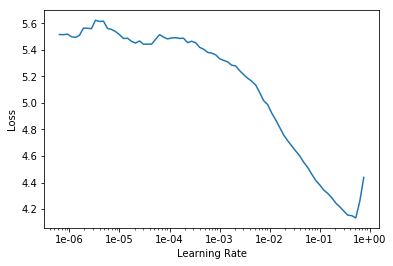

In [5]:
l.recorder.plot()

In [101]:
lr = 1e-4

In [102]:
l.fit_one_cycle(1000, lr)

epoch,train_loss,valid_loss,mape_criterion,rmse_criterion
1,4.335342,5.031596,88.970932,2.242477
2,4.325946,5.012417,89.059509,2.237318
3,4.246887,4.963808,89.587151,2.227736
4,4.261822,4.908476,90.970543,2.214935
5,4.169063,4.848577,93.191681,2.200864
6,4.196635,4.790282,95.408913,2.187648
7,4.201682,4.737153,98.266968,2.174573
8,4.038111,4.681093,101.541885,2.162936
9,4.031818,4.620505,105.530174,2.149150
10,3.955625,4.547956,111.016228,2.131821


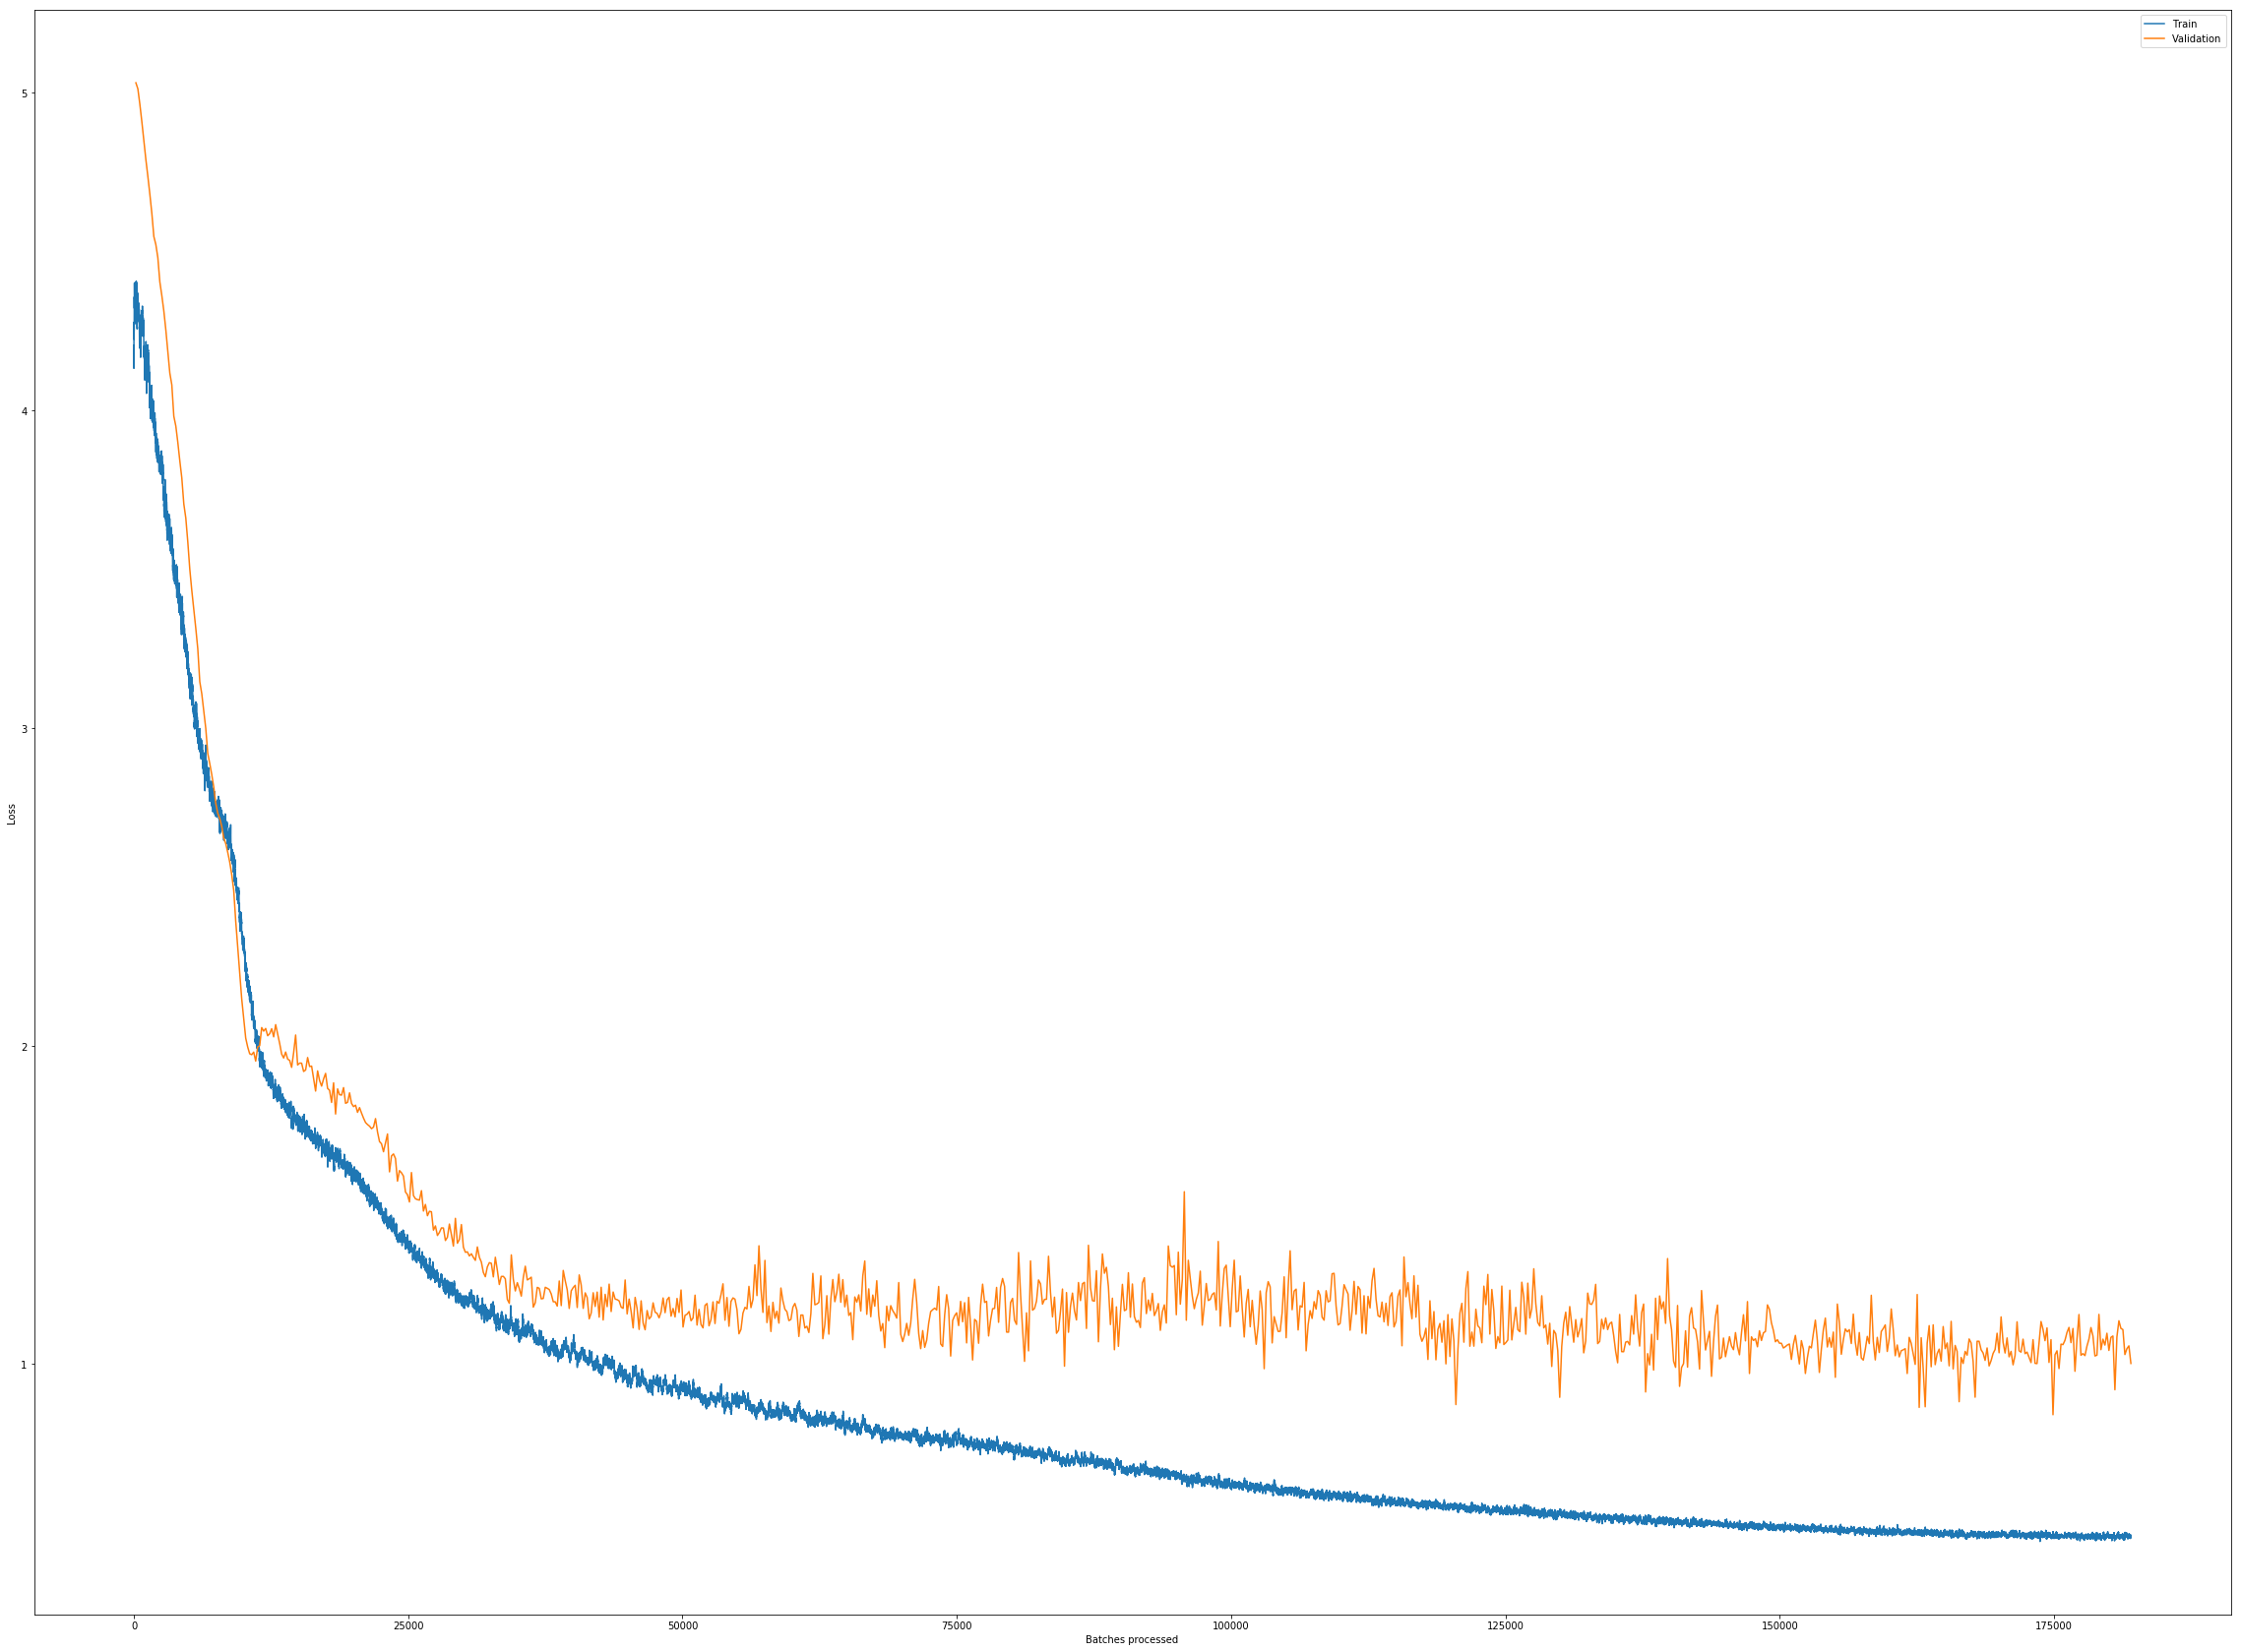

In [114]:
l.recorder.plot_losses()

In [113]:
l.save(f"speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}")

In [20]:
"done"

'done'

In [105]:
val_df = get_results_df(val_dl, l.model)
train_df = get_results_df(train_dl, l.model)

In [111]:
df = train_df

In [115]:
df[:][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,185651.000000,185651.000000,1.856510e+05,185651.000000
mean,1.209736,1.184810,3.507821e-01,101.917557
std,1.436901,1.613917,4.900545e-01,184.357971
min,0.090049,0.008491,4.842877e-07,0.000295
25%,0.345752,0.211613,9.561247e-02,13.881297
50%,0.598681,0.565550,2.032280e-01,33.483063
75%,1.519839,1.394052,4.011498e-01,91.977524
max,10.108776,16.089287,8.719849e+00,3080.909180


In [112]:
df[:][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,185651.000000,185651.000000,1.856510e+05,185651.000000
mean,1.209736,1.184810,3.507821e-01,101.917557
std,1.436901,1.613917,4.900545e-01,184.357971
min,0.090049,0.008491,4.842877e-07,0.000295
25%,0.345752,0.211613,9.561247e-02,13.881297
50%,0.598681,0.565550,2.032280e-01,33.483063
75%,1.519839,1.394052,4.011498e-01,91.977524
max,10.108776,16.089287,8.719849e+00,3080.909180


In [159]:
df[(df.interchange == 0) & (df.tile == 0) & (df.unroll == 1)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,5272.000000,5272.000000,5272.000000,5272.000000
mean,5.139454,5.371452,0.573196,24.085110
std,2.129367,2.290008,0.491706,81.973442
min,0.541461,0.058317,0.000058,0.001177
25%,4.618636,3.869889,0.205381,4.140809
50%,5.469416,5.639095,0.451528,8.874032
75%,6.063024,6.547940,0.809658,15.718910
max,10.828941,13.560771,3.484350,828.611633


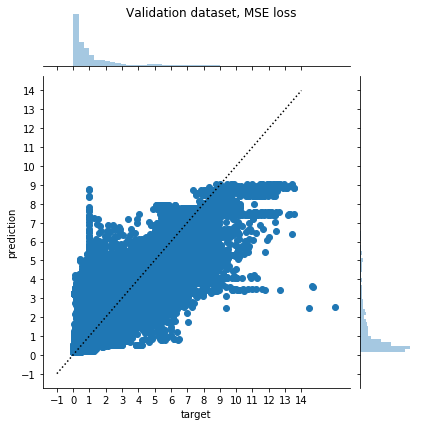

In [99]:
df1 = df[(df.interchange == 0) & (df.tile == 0) & (df.unroll == 1)]
#joint_plot(df1, f"Validation dataset, {loss_func} loss")
df2 = df
joint_plot(df2, f"Validation dataset, {loss_func} loss")